# Import Libraries

In [1]:
import numpy as np 
import pandas as pd 

import os

airlines = pd.read_csv('../input/flight-delays/airlines.csv')
airports = pd.read_csv('../input/flight-delays/airports.csv')
flights = pd.read_csv('../input/flight-delays/flights.csv')

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Cleaning the Data and Get the Big Picture

In [2]:
airlines

,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways
5,OO,Skywest Airlines Inc.
6,AS,Alaska Airlines Inc.
7,NK,Spirit Air Lines
8,WN,Southwest Airlines Co.
9,DL,Delta Air Lines Inc.


In [3]:
airports.head()

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447


In [4]:
flights.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
flights.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5819079 entries, 0 to 5819078
Data columns (total 31 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   YEAR                 5819079 non-null  int64  
 1   MONTH                5819079 non-null  int64  
 2   DAY                  5819079 non-null  int64  
 3   DAY_OF_WEEK          5819079 non-null  int64  
 4   AIRLINE              5819079 non-null  object 
 5   FLIGHT_NUMBER        5819079 non-null  int64  
 6   TAIL_NUMBER          5804358 non-null  object 
 7   ORIGIN_AIRPORT       5819079 non-null  object 
 8   DESTINATION_AIRPORT  5819079 non-null  object 
 9   SCHEDULED_DEPARTURE  5819079 non-null  int64  
 10  DEPARTURE_TIME       5732926 non-null  float64
 11  DEPARTURE_DELAY      5732926 non-null  float64
 12  TAXI_OUT             5730032 non-null  float64
 13  WHEELS_OFF           5730032 non-null  float64
 14  SCHEDULED_TIME       5819073 non-null  float64
 15

**Drop columns that have a lot of missing values**

In [6]:
columns_to_drop = ['CANCELLATION_REASON', 'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 
                  "AIRLINE_DELAY", "LATE_AIRCRAFT_DELAY", "WEATHER_DELAY"]

flights = flights.drop(columns_to_drop, axis=1, errors='ignore')

Let's see how many flights have been canceled or diverted

In [7]:
print(flights['DIVERTED'].value_counts())
print('*' * 30)
print(flights['CANCELLED'].value_counts())

0    5803892
1      15187
Name: DIVERTED, dtype: int64
******************************
0    5729195
1      89884
Name: CANCELLED, dtype: int64


Flights that are 'CANCELLED' or 'DIVERTED' should be removed because they are outliers (rare cases)

In [8]:
flights = flights[flights['CANCELLED'] == 0]   # keep only non-concelled flights
flights = flights[flights['DIVERTED'] == 0]    # keep only non-diverted flights
assert len(flights) == 5819079 - 89884 - 15187 # all flights - conceled - diverted (= 5714008)

**Correlations**

Let's look at how much each attributes correlates with the arrival delay:

In [9]:
corr_matrix = flights.corr()
corr_matrix['ARRIVAL_DELAY'].sort_values(ascending=False)

ARRIVAL_DELAY          1.000000
DEPARTURE_DELAY        0.944672
TAXI_OUT               0.227319
DEPARTURE_TIME         0.159787
WHEELS_OFF             0.155773
TAXI_IN                0.116628
SCHEDULED_DEPARTURE    0.100220
SCHEDULED_ARRIVAL      0.088824
WHEELS_ON              0.058880
ARRIVAL_TIME           0.049876
ELAPSED_TIME           0.029120
FLIGHT_NUMBER          0.018419
DAY                   -0.003097
AIR_TIME              -0.007108
DAY_OF_WEEK           -0.017027
DISTANCE              -0.025444
SCHEDULED_TIME        -0.030029
MONTH                 -0.036793
YEAR                        NaN
DIVERTED                    NaN
CANCELLED                   NaN
Name: ARRIVAL_DELAY, dtype: float64

Let's keep only useful attributes

In [10]:
flights = flights[['MONTH', 'DAY', 'AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 
                    'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 
                    'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'ARRIVAL_DELAY', 'ELAPSED_TIME', ]]
flights.head()

,MONTH,DAY,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,ELAPSED_TIME
0,1,1,AS,ANC,SEA,5,2354.0,-11.0,430,408.0,-22.0,194.0
1,1,1,AA,LAX,PBI,10,2.0,-8.0,750,741.0,-9.0,279.0
2,1,1,US,SFO,CLT,20,18.0,-2.0,806,811.0,5.0,293.0
3,1,1,AA,LAX,MIA,20,15.0,-5.0,805,756.0,-9.0,281.0
4,1,1,AS,SEA,ANC,25,24.0,-1.0,320,259.0,-21.0,215.0


**Check for null values**

In [11]:
flights.isnull().sum()

MONTH                  0
DAY                    0
AIRLINE                0
ORIGIN_AIRPORT         0
DESTINATION_AIRPORT    0
SCHEDULED_DEPARTURE    0
DEPARTURE_TIME         0
DEPARTURE_DELAY        0
SCHEDULED_ARRIVAL      0
ARRIVAL_TIME           0
ARRIVAL_DELAY          0
ELAPSED_TIME           0
dtype: int64

**Summary of the numerical attributes**

In [12]:
flights.describe()

,MONTH,DAY,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,ELAPSED_TIME
count,5.714008e+06,5.714008e+06,5.714008e+06,5.714008e+06,5.714008e+06,5.714008e+06,5.714008e+06,5.714008e+06,5.714008e+06
mean,6.547799e+00,1.570759e+01,1.328907e+03,1.335066e+03,9.294842e+00,1.493187e+03,1.476373e+03,4.407057e+00,1.370062e+02
std,3.397421e+00,8.774394e+00,4.835251e+02,4.964198e+02,3.688972e+01,5.069011e+02,5.259730e+02,3.927130e+01,7.421107e+01
min,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,-8.200000e+01,1.000000e+00,1.000000e+00,-8.700000e+01,1.400000e+01
25%,4.000000e+00,8.000000e+00,9.160000e+02,9.210000e+02,-5.000000e+00,1.110000e+03,1.058000e+03,-1.300000e+01,8.200000e+01
50%,7.000000e+00,1.600000e+01,1.325000e+03,1.330000e+03,-2.000000e+00,1.520000e+03,1.512000e+03,-5.000000e+00,1.180000e+02
75%,9.000000e+00,2.300000e+01,1.730000e+03,1.740000e+03,7.000000e+00,1.917000e+03,1.916000e+03,8.000000e+00,1.680000e+02
max,1.200000e+01,3.100000e+01,2.359000e+03,2.400000e+03,1.988000e+03,2.400000e+03,2.400000e+03,1.971000e+03,7.660000e+02


**Distribution of the arrival delay attribute**

Text(0, 0.5, 'Number of flights')

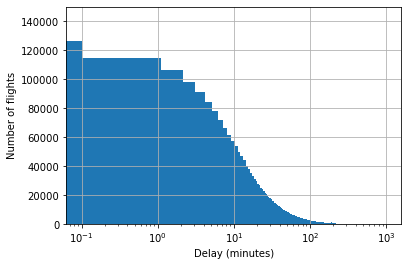

In [13]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
flights.ARRIVAL_DELAY.hist(ax=ax, bins=1000, range=(-10, 1000))
ax.set_xscale('log')
plt.ylim(0, 150000)
plt.xlabel('Delay (minutes)')
plt.ylabel('Number of flights')

# Exploration with Regard to the Mean Delay

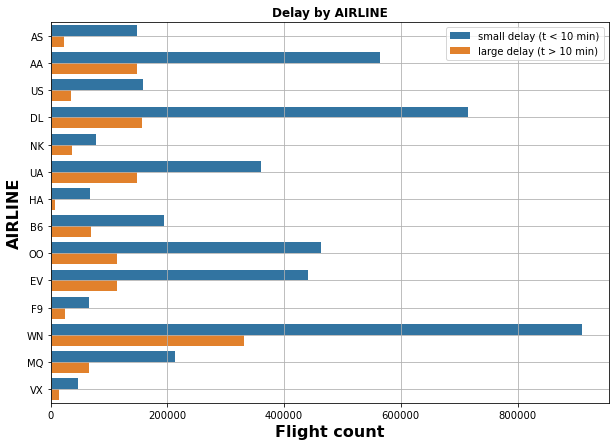

In [14]:
# Inspired from this kaggle kernel: https://www.kaggle.com/fabiendaniel/predicting-flight-delays-tutorial
import seaborn as sns 

def delay_by_attribute(attribute, df=flights, figsize=(10, 7)):
    # Delay with less than 10 min are mapped to 0 otherwise they are mapped to 1
    delay_type = lambda x: 0 if x < 10 else 1
    flights['DELAY_TYPE'] = flights['DEPARTURE_DELAY'].apply(delay_type)
    
    plt.figure(1, figsize=figsize)
    ax = sns.countplot(y=attribute, hue='DELAY_TYPE', data=df)
    
    plt.xlabel('Flight count', fontsize=16, weight='bold')
    plt.ylabel(attribute, fontsize=16, weight='bold')
    plt.title(f'Delay by {attribute}', weight='bold')
    L = plt.legend()
    L.get_texts()[0].set_text('small delay (t < 10 min)')
    L.get_texts()[1].set_text('large delay (t > 10 min)')
    plt.grid(True)
    plt.show()

delay_by_attribute('AIRLINE')

We can see that the proportion between small and large delay is related to the airline, for example: the airline **UA** (United Air Lines Inc.) almost 50% of their flights have a large delay, on the other hand, the airline **DL** (Delta Air Lines Inc.) ~25% of their flights have a large delay.

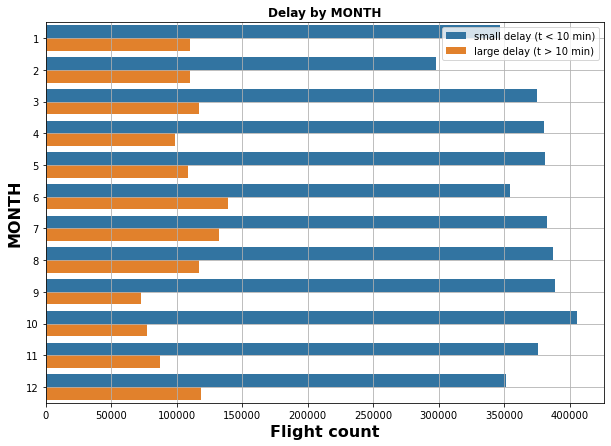

In [15]:
delay_by_attribute('MONTH')

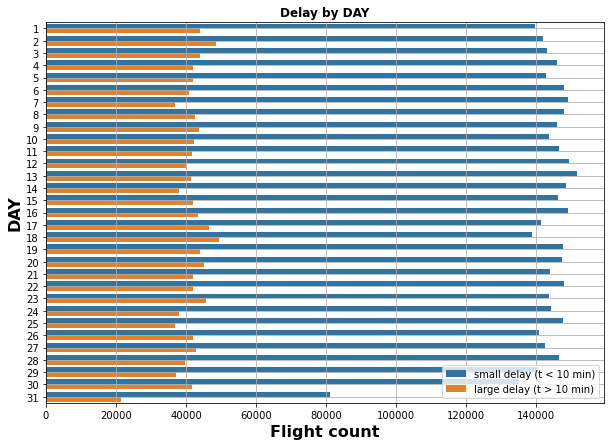

In [16]:
delay_by_attribute('DAY')

From the correlation matrix and the plots above we can see that delays are not correlated with months nor days.

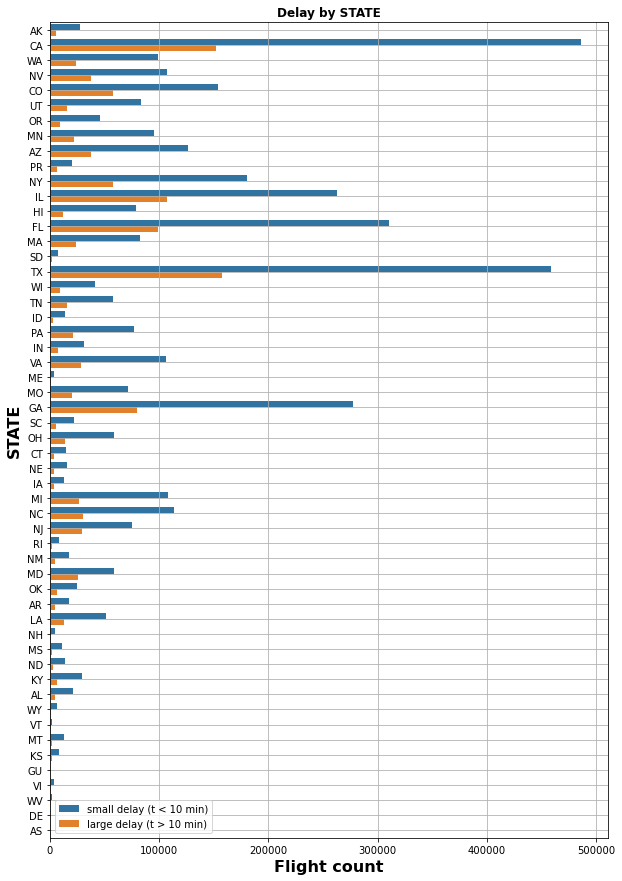

In [17]:
result = pd.merge(flights[['ORIGIN_AIRPORT', 'DELAY_TYPE']], 
                  airports[['IATA_CODE', 'STATE']], 
                  left_on='ORIGIN_AIRPORT', right_on='IATA_CODE')

delay_by_attribute('STATE', df=result, figsize=(10, 15))

**Statistiques of outliers**

if we consider delays of more than 10 minutes to be significant delays, than let's see how much in percentage these delays represent of the dataset

In [18]:
nb_of_large_delays = (flights.ARRIVAL_DELAY > 10).sum()
percent_of_large_delays = np.round(nb_of_large_delays * 100 / len(flights), 2)
print('There are {} flights with large delays (more than 10min), which represent {}% of the flights'
      .format(nb_of_large_delays, percent_of_large_delays))

There are 1257676 flights with large delays (more than 10min), which represent 22.01% of the flights


In [19]:
# Number of flights that have more than 150min (2.5h) delay
nb_of_rare_delays = (flights.ARRIVAL_DELAY > 150).sum()
percent_of_rare_delays = np.round(nb_of_rare_delays * 100 / len(flights), 1)

# percent of rare delays with regard to large delays
percent_rare_large = np.round((nb_of_rare_delays * 100 / nb_of_large_delays), 1)
print(
    'There are {} flights with rare delays (> 5h) which represent {}% of all flights, which also represent {}% of large delays'
     .format(nb_of_rare_delays, percent_of_rare_delays, percent_rare_large))

There are 72438 flights with rare delays (> 5h) which represent 1.3% of all flights, which also represent 5.8% of large delays


 <table style="width:50%; border: 1px solid black; border-collapse: collapse;">
  <tr>
    <th></th>
    <th>All flights</th>
    <th>Large delays (> 10min)</th>
    <th>Rare delays (> 150min)</th>
  </tr>
    <tr>
    <td>All flights</td>
    <td>100%</td>
    <td>/</td>
    <td>/</td>
  </tr>
  <tr>
    <td>Large delays (> 10min)</td>
    <td>22%</td>
    <td>100%</td>
    <td>/</td>
  </tr>
  <tr>
    <td>Rare delays (> 150min)</td>
    <td>1.3%</td>
    <td>5.8%</td>
    <td>100%</td>
  </tr>
</table> 

We can think of delays longer than 2.5 hours as outliers, so we need to remove them from the dataset

In [20]:
# Keep only delays less than 150min
flights = flights[flights.ARRIVAL_DELAY < 150]

# Split the Dataset

In [21]:
flights['ORIGIN_AIRPORT'] = flights['ORIGIN_AIRPORT'].astype(str)
flights['DESTINATION_AIRPORT'] = flights['DESTINATION_AIRPORT'].astype(str)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [22]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(flights, test_size=0.2, random_state=42)

X_train = train_set.drop("ARRIVAL_DELAY", axis=1)
y_train = train_set['ARRIVAL_DELAY'].copy()

X_test = test_set.drop('ARRIVAL_DELAY', axis=1)
y_test = test_set['ARRIVAL_DELAY'].copy()

# Encoding Categorical Attributes

I chose embedding to convert categorical attributes to numbers: ordinal encoding is not good since the model will assume that two nearby values are more familiar than to distant values, which is obviously not the case for our categorical attributes. Also, our categorical attributes have a large number of categories (629 for airports), so one-hot encoding will result in a large number of features (more than 1000). This will affect performance and training.

In [23]:
dest_airport = X_train['DESTINATION_AIRPORT'].unique()
orig_airport = X_train['ORIGIN_AIRPORT'].unique()
airports = np.unique(np.hstack([dest_airport, orig_airport]))
airlines = X_train['AIRLINE'].unique()

In [24]:
from sklearn.base import BaseEstimator, TransformerMixin
import tensorflow as tf 

class EmbeddingTransorfmer(BaseEstimator, TransformerMixin):
    def __init__(self, vocab, n_oov_buckets=10, embedding_dim=10):
        self.n_oov_buckets = n_oov_buckets
        self.vocab = vocab
        self.embedding_dim = embedding_dim
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        vocab = tf.constant(self.vocab)
        indices = tf.range(len(vocab), dtype=tf.int64)
        table_init = tf.lookup.KeyValueTensorInitializer(vocab, indices)
        table = tf.lookup.StaticVocabularyTable(table_init, self.n_oov_buckets)
        
        embedding_dim = self.embedding_dim
        embedding_matrix = tf.random.uniform([len(vocab) + self.n_oov_buckets, embedding_dim])
        cat_indices = table.lookup(tf.constant(X))
        return tf.nn.embedding_lookup(embedding_matrix, cat_indices).numpy()

# Preprocessing the Input Features

In [25]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

num_pipeline = Pipeline([
    ('std_scaler', StandardScaler()),
])

X_train_num = X_train.drop(['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT'], axis=1, errors='ignore')
num_attribs = list(X_train_num)

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat1', EmbeddingTransorfmer(airports), 'ORIGIN_AIRPORT'),
    ('cat2', EmbeddingTransorfmer(airports), 'DESTINATION_AIRPORT'),
    ('cat3', EmbeddingTransorfmer(airlines), 'AIRLINE')
])

X_train_prepared = full_pipeline.fit_transform(X_train)

# Training and Evaluation

## Ridge Regression

In [26]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

ridge_reg = Ridge(alpha=0.01, random_state=42)
ridge_reg.fit(X_train_prepared, y_train)

Ridge(alpha=0.01, random_state=42)

Let's try to predict some data

In [27]:
some_data = X_train.iloc[:5]
some_labels = y_train.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:", ridge_reg.predict(some_data_prepared))

Predictions: [-10.05932458  -9.28800082  -3.66917697  10.57917597   3.34607729]


In [28]:
print("Labels:", list(some_labels))

Labels: [-13.0, 5.0, -19.0, 8.0, 4.0]


We can see that the predictions are not exactly accurate! Let's measure the RMSE on the whole training set:

In [29]:
predictions = ridge_reg.predict(X_train_prepared)
ridge_mse = mean_squared_error(y_train, predictions)
ridge_rmse = np.sqrt(ridge_mse)
'{:.2f} min'.format(ridge_rmse)

'12.37 min'

The typical error the model make is 12.37min which is not very good. 

Unfortunatly, I couldn't use other models because training took too long, so let's try fine-tuning the ridge regression model.

## Fine Tuning Using Grid Search

In [30]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'alpha': [0.01, 0.1, 1, 10, 100]},
    {'solver': ['cholesky', 'lsqr']}
]

grid_search = GridSearchCV(ridge_reg, param_grid, cv=4,
                          scoring='neg_mean_squared_error',
                          return_train_score=True,
                          verbose=2)
grid_search.fit(X_train_prepared, y_train)

Fitting 4 folds for each of 7 candidates, totalling 28 fits
[CV] END .........................................alpha=0.01; total time=   4.6s
[CV] END .........................................alpha=0.01; total time=   4.5s
[CV] END .........................................alpha=0.01; total time=   4.5s
[CV] END .........................................alpha=0.01; total time=   4.6s
[CV] END ..........................................alpha=0.1; total time=   4.6s
[CV] END ..........................................alpha=0.1; total time=   4.6s
[CV] END ..........................................alpha=0.1; total time=   4.5s
[CV] END ..........................................alpha=0.1; total time=   4.7s
[CV] END ............................................alpha=1; total time=   4.5s
[CV] END ............................................alpha=1; total time=   4.5s
[CV] END ............................................alpha=1; total time=   4.6s
[CV] END ........................................

GridSearchCV(cv=4, estimator=Ridge(alpha=0.01, random_state=42),
             param_grid=[{'alpha': [0.01, 0.1, 1, 10, 100]},
                         {'solver': ['cholesky', 'lsqr']}],
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=2)

In [31]:
np.sqrt(-grid_search.best_score_)

12.372311284393446

# Evaluation on the Test Set

In [32]:
model = grid_search.best_estimator_

X_test_prepared = full_pipeline.transform(X_test)
test_predictions = model.predict(X_test_prepared)
test_mse = mean_squared_error(y_test, test_predictions)
test_rmse = np.sqrt(test_mse)

In [33]:
test_rmse

12.58277815286772

# References

* [Predicting flight delays [Tutorial]](https://www.kaggle.com/fabiendaniel/predicting-flight-delays-tutorial)
* [Flight_Delay_Prediction](https://www.kaggle.com/hrishikeshmalkar/flight-delay-prediction)
* https://github.com/Djinny/Formation-Data-Scientist/tree/master/Pr%C3%A9dire%20le%20retard%20d'avions
* https://github.com/xmontamat/OC_DataScience/tree/master/OC_Project4_Flights_delay